# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow those simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November 4th, 2025 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

In the exercises below, I describe the exercises in a general way. Drawing in the right parts of the exercises is part of the assignment. (That way we're helping you get a little bit more ready for the Final Project, where you have to decide what information to include in your report and analysis).


# Part 0: Common Code and "Less Relevant" Code
Here we import the necessary packages.

In [174]:
import networkx as nx
import pickle
import requests
from io import BytesIO
import re
import html
from collections import Counter
import math
import numpy as np
import matplotlib.pyplot as plt

## Tokenizing the Wikipedia pages of the rock musicians.
- This is probably not the most intuitive way to get the wikitext, but from the graph we can easily retrieve the name of the Wiki-pages.

In [ ]:
url = 'https://raw.githubusercontent.com/hoboldi/Social-Graphs-and-Interactions/main/Misc/MusicianGraph.pickle'
r = requests.get(url)
r.raise_for_status()

G = pickle.load(BytesIO(r.content))
print(G)

- Based on the names of the nodes, we retrieve the Wiki-pages.
- We also save these Wiki-pages for convenience as the many calls to the website can take a long time, so for the convenience of the grader we pickled them.

In [141]:
# Get the name of the artists
artists = list(G.nodes())
print(artists[:10])

# Define API and HEADERS
API = "https://en.wikipedia.org/w/api.php"
HEADERS = {"User-Agent": "MyWikipediaClient/1.0 (example@example.com)"}

# This method is based on this: https://stackoverflow.com/a/62225015 and this line was partly done with ChatGPT data["query"]["pages"][0]["revisions"][0]["slots"]["main"]["content"].
def get_wikitext(title: str) -> str:
    params = {
        "action": "query",
        "prop": "revisions",
        "titles": title,
        "rvslots": "main",
        "rvprop": "content",
        "format": "json",
        "formatversion": "2",
    }

    response = requests.get(API, params=params, headers=HEADERS, timeout=20)
    response.raise_for_status()

    data = response.json()

    return data["query"]["pages"][0]["revisions"][0]["slots"]["main"]["content"]

artist_pages = {}

for artist in artists:
    artist_pages[artist] = get_wikitext(artist)

with open('Misc/ArtistPages.pickle', 'wb') as f:
    pickle.dump(artist_pages, f)

print(list(artist_pages.values())[0][:10])

['Funkadelic', 'Parliament-Funkadelic', 'AllMusic', 'Jimi_Hendrix', 'Sly_and_the_Family_Stone', 'Cream_(band)|Cream', 'Slayer', 'Metallica', 'Megadeth', 'Anthrax_(American_band)|Anthrax']
{{short de


- To avoid the long runtime, with this we can load the ArtistPages faster. (This still takes a good 30s, but much better than the 5m of the other version.)

In [162]:
url = "https://raw.githubusercontent.com/hoboldi/Social-Graphs-and-Interactions/main/Misc/ArtistPages.pickle"
artist_pages = pickle.load(BytesIO(requests.get(url).content))

print(list(artist_pages.values())[0][:10])

{{short de


## Tokenizing the texts
- In this part we convert the raw wikitext to tokenized version.
- This part (as recommended) was done with the help of ChatGPT.

In [163]:
# In this part we define some regular expressions for filtering out specific wikitext (and html) elements.

# Filter out comments.
RE_COMMENTS   = re.compile(r'<!--.*?-->', flags=re.DOTALL)
# Filter out citations (refs).
RE_REF_TAGS   = re.compile(r'<ref[^>]*>.*?</ref>|<ref[^>]*/>', flags=re.DOTALL|re.IGNORECASE)
# Filter out HTML tags.
RE_HTML_TAGS  = re.compile(r'</?[^>]+?>', flags=re.DOTALL)
# Filter out non-nested templates. (flag moved to flags=...)
RE_TEMPLATES  = re.compile(r'\{\{[^{}]*\}\}', flags=re.DOTALL)
# Filter out tables.
RE_TABLES     = re.compile(r'\{\|.*?\|\}', flags=re.DOTALL)
# Filter out file tags.
RE_FILES      = re.compile(r'\[\[(?:File|Image):[^\]]+\]\]', flags=re.IGNORECASE)
# Filter out external links.
RE_EXTLINKS   = re.compile(r'\[(?:https?://|ftp://)[^\s\]]+(?:\s+[^\]]+)?\]')
# Filter out internal links.
RE_LINKS      = re.compile(r'\[\[([^[\]|#]+)(?:#[^\]|]+)?(?:\|([^\]]+))?\]\]')
# Filter out headings.
RE_HEADING    = re.compile(r'^\s*=+[^=\n]+?=+\s*$', flags=re.MULTILINE)
# Filter out formatting.
RE_FORMATTING = re.compile(r"'''+|''")
# Filter out list/definition prefixes.
RE_LIST_BUL   = re.compile(r'^[*#;:]+', flags=re.MULTILINE)
# Filter out remaining parts of tables.
RE_TABLE_ROWS = re.compile(r'^\s*\|\+.*$|^\s*\|[-!].*$', flags=re.MULTILINE)
# Filter out raw urls.
RE_URLS       = re.compile(r'(?:https?://|ftp://)\S+')
# Filter out HTML entities.
RE_ENTITY     = re.compile(r'&[A-Za-z#0-9]+;')

# A lambda expression to split a text into words.
WORD_SPLIT = lambda s: re.findall(r'[A-Za-z]+', s)

# This function removes nested "{{...}}" templates by applying regex until nothing changes.
def _strip_templates(text: str) -> str:
    prev = None
    while prev != text:
        prev = text
        text = RE_TEMPLATES.sub('', text)
    return text

# This function converts a wikitext into simple text.
def wikitext_to_words(text: str, lower: bool = True) -> list[str]:
    if not text:
        return []

    if lower:
        text = text.casefold()

    # Apply the previously defined regexes.
    text = RE_COMMENTS.sub(' ', text)
    text = RE_REF_TAGS.sub(' ', text)
    text = RE_TABLES.sub(' ', text)
    text = _strip_templates(text)
    text = RE_FILES.sub(' ', text)
    text = RE_EXTLINKS.sub(' ', text)
    text = RE_HTML_TAGS.sub(' ', text)

    # Remove the text of links.
    def _keep_link(m):
        target, disp = m.group(1), m.group(2)
        return disp if disp else target
    text = RE_LINKS.sub(_keep_link, text)

    # Apply another batch of previously defined filters.
    text = RE_HEADING.sub(' ', text)
    text = RE_LIST_BUL.sub(' ', text)
    text = RE_TABLE_ROWS.sub(' ', text)
    text = RE_FORMATTING.sub(' ', text)
    text = RE_URLS.sub(' ', text)
    text = RE_ENTITY.sub(lambda m: html.unescape(m.group(0)), text)

    # Collapse whitespace.
    text = ' '.join(text.split())

    words = WORD_SPLIT(text)
    if lower:
        words = [w.lower() for w in words]

    return words

- Applying the tokenization function to our wikitext pages.

In [164]:
text_pages = {artist: wikitext_to_words(page) for artist, page in artist_pages.items()}

print(list(text_pages.values())[0][:20])

['funkadelic', 'was', 'an', 'american', 'funk', 'rock', 'funkadelic', 'initially', 'formed', 'as', 'a', 'backing', 'band', 'for', 'clinton', 's', 'vocal', 'group', 'the', 'parliaments']


- After we tokenized the text we can sum the counts.

In [165]:
tokenized_pages = {artist: Counter(text) for artist, text in text_pages.items()}

print(list(tokenized_pages.values())[0].most_common(20))

dict_keys(['Funkadelic', 'Parliament-Funkadelic', 'AllMusic', 'Jimi_Hendrix', 'Sly_and_the_Family_Stone', 'Cream_(band)|Cream', 'Slayer', 'Metallica', 'Megadeth', 'Anthrax_(American_band)|Anthrax', 'Iron_Maiden', 'Black_Sabbath', 'Judas_Priest', 'Scorpions_(band)|Scorpions', 'Motörhead', 'Alice_in_Chains', 'Ozzy_Osbourne', 'Sepultura', 'Pantera', 'Tool_(band)|Tool', 'Slipknot_(band)|Slipknot', 'Lamb_of_God_(band)|Lamb_of_God', 'Trivium_(band)|Trivium', 'Primus_(band)|Primus', 'Volbeat', 'Led_Zeppelin', 'Deep_Purple', 'Kiss_(band)|Kiss', 'Van_Halen', 'Aerosmith', 'Ted_Nugent', 'Rush_(band)|Rush', 'Rainbow_(rock_band)|Rainbow', 'Accept_(band)|Accept', 'Avenged_Sevenfold', 'Bullet_for_My_Valentine', 'System_of_a_Down', 'Killswitch_Engage', 'Lacuna_Coil', 'Flyleaf_(band)|Flyleaf', 'Skillet_(band)|Skillet', 'Breaking_Benjamin', 'Staind', '3_Doors_Down', "Jane's_Addiction", 'Disturbed_(band)|Disturbed', 'Stone_Sour', 'Three_Days_Grace', 'Seether', '10_Years_(band)|10_Years', 'P.O.D.', 'rock_

# Part 1: Analyze the network

The questions in this part are based on Lecture 5.

* Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
   - It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
   - I would like you to include concepts like centrality and assortativity in your analysis.
   - Use a network backbone in your analysis.
   - In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
   - **Note**: As I write above, an important part of the exercise consists is *selecting the right elements of the lecture* to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network.

# Part 2: Genres and communities and plotting

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.

# Part 3: TF-IDF to understand genres and communities

The questions below  are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.


# Part 4: Sentiment of the artists and communities

The questions below are based on Lecture 8

* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

## Part 4.1: Calculate the sentiment of the Artist Pages


## Part 4.1.3: Calculating the sentiment of the Artists and Calculating Basic Metrics
- **Q:** Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1).


In [166]:
# We have uploaded the Wordlist to our GitHub repository for easier access.
url = "https://raw.githubusercontent.com/hoboldi/Social-Graphs-and-Interactions/main/Misc/Sentiment_Data.txt"
wordlist = requests.get(url).text

print(wordlist[:53])

lines = wordlist.splitlines()[3:]

labmt = {}
for ln in lines:
    ln = ln.strip()
    if not ln or ln.startswith('#'):
        continue
    w, s = ln.split()[:2]
    try:
        labmt[w.lower()] = float(s)
    except ValueError:
        pass

print(list(labmt.items())[:10])

labMIT-1.0.txt
language assessment by Mechanical Turk
[('laughter', 1.0), ('happiness', 2.0), ('love', 3.0), ('happy', 4.0), ('laughed', 5.0), ('laugh', 6.0), ('laughing', 7.0), ('excellent', 8.0), ('laughs', 9.0), ('joy', 10.0)]


- **Q:** Describe briefly how the list was generated.
- **A:** First, they composed a list of the most frequent words, these words were the combined list of most frequent words from Twitter, Google Books, Music Lyrics and the New York Times. Second, they used the crowdsourcing service of the Mechanical Turk where the users could vote on the "happiness of the word" based on a 1-9 scale where they could choose 1,3,5,7,9. The study avoided word preprocessings. The study als omitted completely neutral words like: "the", "and" or "of".

- **Q:** Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).


In [167]:
# The function which calculates the sentiment of a given list of tokens.
def sentiment(counts, labmt, delta=1.0):
    num = den = 0.0
    for w, c in counts.items():
        h = labmt.get(w)
        if h is None:
            continue

        # Removing "unimportant" words (very neutral words)
        if abs(h - 5.0) <= delta:
            continue

        num += c * h
        den += c

    return num / den if den > 0 else math.nan

print(sentiment(list(tokenized_pages.values())[0],labmt))

5076.217508417509


- **Q:** Iterage over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.

In [168]:
sentiments = {artist: sentiment(tokenized_page, labmt) for artist, tokenized_page in tokenized_pages.items()}

nx.set_node_attributes(G, sentiments, name='sentiment')

- Calculate the average sentiment across all the pages. Also calculate the median, variance, 25th percentile, 75th percentile.


In [173]:
avg_sentiment = np.mean(list(sentiments.values()))

print(f"Average sentiment of the artists is: {avg_sentiment}")

median = np.median(list(sentiments.values()))

print(f"Median sentiment of the artists is: {median}")

variance = np.var(list(sentiments.values()))

print(f"Variance of the sentiments is: {variance}")

first_quartier = np.percentile(list(sentiments.values()),25)

print(f"The 25th percentile is: {first_quartier}")

third_quartier = np.percentile(list(sentiments.values()),75)

print(f"The 75th percentile is: {third_quartier}")

Average sentiment of the artists is: 4925.249205788728
Median sentiment of the artists is: 4925.996990218209
Variance of the sentiments is: 64660.54369995385
The 25th percentile is: 4800.1942517165735
The 75th percentile is: 5048.572903548605


- Remember histograms? Create a histogram of all of the artists's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2). Add the mean, meadian, ect from above to your plot.

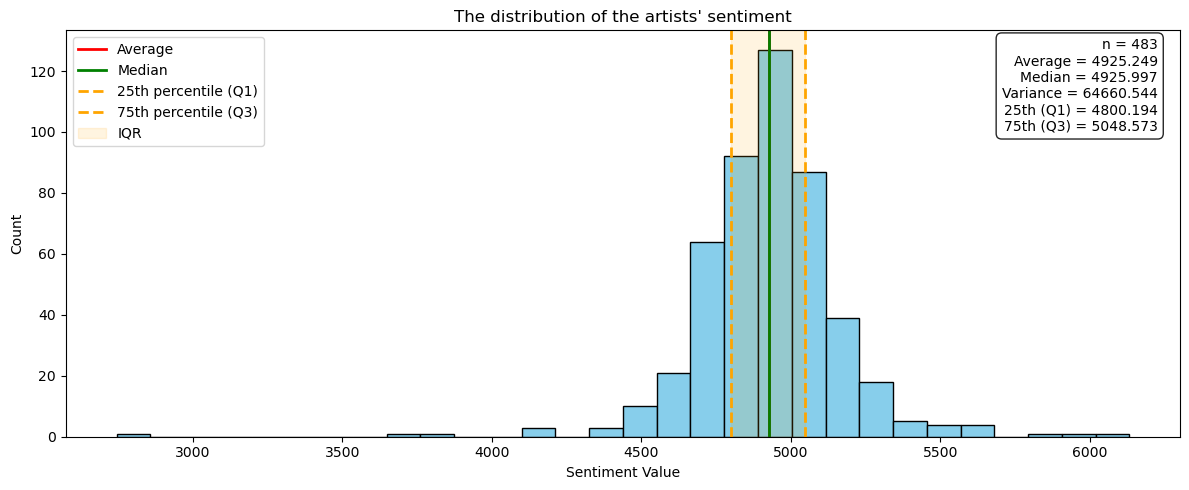

In [181]:
plt.figure(figsize=(12, 5))
plt.hist(sentiments.values(), bins=30, color="skyblue", edgecolor="black")
plt.title("The distribution of the artists' sentiment")
plt.xlabel("Sentiment Value")
plt.ylabel("Count")

# lines + IQR band using your names
plt.axvline(avg_sentiment, color="red", linewidth=2, label="Average")
plt.axvline(median, color="green", linewidth=2, label="Median")
plt.axvline(first_quartier, color="orange", linestyle="--", linewidth=2, label="25th percentile (Q1)")
plt.axvline(third_quartier, color="orange", linestyle="--", linewidth=2, label="75th percentile (Q3)")
plt.axvspan(first_quartier, third_quartier, color="orange", alpha=0.12, label="IQR")

# stats box (shows your variable names/values)
stats_txt = (
    f"n = {len(sentiments.values())}\n"
    f"Average = {avg_sentiment:.3f}\n"
    f"Median = {median:.3f}\n"
    f"Variance = {variance:.3f}\n"
    f"25th (Q1) = {first_quartier:.3f}\n"
    f"75th (Q3) = {third_quartier:.3f}"
)
plt.text(
    0.98, 0.98, stats_txt,
    transform=plt.gca().transAxes, ha="right", va="top",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.85)
)

plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

- Who are the 10 artists with happiest and saddest pages?

In [185]:
lowest_10 = sorted(sentiments.items(), key=lambda x: x[1])[:10]

print("The 10 artists with the lowest sentiment values:")
for artist, value in lowest_10:
    print(f"{artist}: {value:.3f}")

print()

lowest_10 = sorted(sentiments.items(), key=lambda x: x[1])[-10:]

print("The 10 artists with the highest sentiment values:")
for artist, value in lowest_10:
    print(f"{artist}: {value:.3f}")

The 10 artists with the lowest sentiment values:
Paul_McCartney_and_Wings|Wings: 2745.000
Scorpions_(band)|Scorpions: 3730.702
Bo_Diddley: 3788.600
Icehouse_(band)|Icehouse: 4175.346
Queen_(band)|Queen: 4177.017
Lifehouse_(band)|Lifehouse: 4178.239
Survivor_(band)|Survivor: 4326.077
Cold_Chisel: 4358.423
Tracy_Chapman: 4431.367
Edgar_Winter|The_Edgar_Winter_Group: 4460.173

The 10 artists with the highest sentiment values:
Warrant_(American_band)|Warrant: 5496.677
Ambrosia_(band)|Ambrosia: 5527.304
Saliva_(band)|Saliva: 5530.064
Ghost_(Swedish_band)|Ghost: 5577.101
Heart_(band)|Heart: 5624.920
Traffic_(band)|Traffic: 5644.976
Anthrax_(American_band)|Anthrax: 5673.278
Poison_(American_band)|Poison: 5875.143
10_Years_(band)|10_Years: 5919.000
AC_DC: 6132.000


*Exercise*: Community sentiment distribution.

> * Last week we calculated the stuctural communities of the graph. For this exercise, we use those communities (just the 10 largest ones). Specifically, you should calculate the average the average sentiment of the nodes in each community to find a *community level sentiment*.
>   - Name each community by its three most connected bands. (Or feed the list of bands in each community and ask the LLM to come up with a good name for the community).
>   - What are the three happiest communities?
>   - what are the three saddest communities?
>   - Do these results confirm what you can learn about each community by comparing to the genres, checking out the word-clouds for each community, and reading the wiki-pages?
> * Compare the sentiment of the happiest and saddest communities to the overall (entire network) distribution of sentiment that you calculated in the previous exercise. Are the communities very differenct from the average? Or do you find the sentiment to be quite similar across all of the communities?

**Note**: Calculating sentiment may take a long time, so arm yourself with patience as your code runs (remember to check that it runs correctly, before waiting patiently). Further, these tips may speed things up. And save somewhere, so you don't have to start over.

**Tips for speed**
* If you use `freqDist` prior to finding the sentiment, you only have to find it for every unique word and hereafter you can do a weighted mean.
* More tips for speeding up loops https://wiki.python.org/moin/PythonSpeed/PerformanceTips#Loops

## Part 4.2: Community Sentiment Distribution
###